In [1]:
import ondil
import numpy as np
from sklearn.datasets import load_diabetes, make_regression
import matplotlib.pyplot as plt
from pprint import pprint

np.set_printoptions(precision=3, suppress=True)
print(ondil.__version__)

0.1.11


# Batch Estimation

In [2]:
## Diabetes data set
## Add intercept (will not be regularized)

X, y = load_diabetes(return_X_y=True)

## OLS

In [ ]:
equation = {
    0: "all",
    1: "all",
}

online_gamlss_ols = ondil.estimators.OnlineDistributionalRegression(
    distribution=ondil.Normal(),
    method="ols",
    equation=equation,
    fit_intercept=True,
)

online_gamlss_ols.fit(X, y)

print("OLS Coefficients \n")
pprint(online_gamlss_ols.beta)

OLS Coefficients 

{0: array([152.004,  -0.621, -12.37 ,  23.288,  15.373, -28.417,  15.796,
        -0.309,   6.318,  33.086,   2.393]),
 1: array([ 3.986, -0.031, -0.02 ,  0.067,  0.045,  0.048, -0.084,  0.007,
        0.043, -0.024,  0.036])}


## LASSO

In [ ]:
import ondil

dist = ondil.distributions.StudentT()
equation = {
    0: "all",  # Can also use: "intercept" or pass a numpy array with indices / boolean
    1: "all",
    2: "all",
}

online_gamlss_lasso = ondil.estimators.OnlineDistributionalRegression(
    distribution=dist,
    method="lasso",
    equation=equation,
    fit_intercept=True,
    ic="bic",
)
online_gamlss_lasso.fit(X, y)

print("LASSO Coefficients \n")
print(np.vstack([*online_gamlss_lasso.beta.values()]).T)

LASSO Coefficients 

[[151.799   3.917   2.735]
 [ -0.     -0.      0.   ]
 [-10.761  -0.      0.   ]
 [ 24.583   0.035  -0.292]
 [ 14.173   0.     -0.   ]
 [ -5.517   0.      0.   ]
 [ -0.     -0.      0.   ]
 [-10.868  -0.      0.   ]
 [  0.      0.     -0.   ]
 [ 25.537   0.     -0.   ]
 [  1.749   0.     -0.163]]


# Incremental Fit

In [ ]:
# Fit for all until the last observation
import ondil.distributions


online_gamlss_lasso = ondil.estimators.OnlineDistributionalRegression(
    distribution=ondil.distributions.StudentT(),
    method="lasso",
    equation=equation,
    ic="bic",
)
online_gamlss_lasso.fit(X=X[:-1, :], y=y[:-1])

print("Coefficients for the first N-1 observations \n")
print(np.vstack([*online_gamlss_lasso.beta.values()]).T)

Coefficients for the first N-1 observations 

[[152.023   3.917   2.737]
 [ -0.     -0.      0.   ]
 [-10.787  -0.      0.   ]
 [ 24.56    0.035  -0.296]
 [ 14.2     0.     -0.   ]
 [ -5.533   0.      0.   ]
 [ -0.     -0.      0.   ]
 [-10.835  -0.      0.   ]
 [  0.      0.     -0.   ]
 [ 25.511   0.     -0.   ]
 [  1.726   0.     -0.163]]


In [9]:
online_gamlss_lasso.update(X[[-1], :], y[[-1]])

print("\nCoefficients after update call \n")
print(np.vstack([*online_gamlss_lasso.beta.values()]).T)


Coefficients after update call 

[[152.165   3.932   3.471]
 [ -0.738  -0.044   0.514]
 [-12.52   -0.099   0.611]
 [ 24.565   0.037  -0.229]
 [ 15.299   0.069  -0.226]
 [-33.405  -0.409   2.868]
 [ 19.284   0.388  -2.352]
 [  2.459  -0.013  -0.503]
 [  7.418  -0.097   0.267]
 [ 35.113   0.189  -1.481]
 [  2.4     0.042  -0.245]]


# Estimators and EstimationMethods

`ondil` allows for the separation of estimation method (LASSO, OLS, ...) and the model (a simple linear model, a distributional regression) and therefore provides ample flexibility for the modeller. 

For example, we might want to estimate a simple linear model using the LASSO on a regularization path that is only 10 regularization steps(lambdas) long (instead of the default 100, as in e.g. `R`s `glmnet`) and box-constrain our coefficients to be positive. This can be achieved simply by the following few lines.

############################ OLS ##########################
[ -0.368 -11.856  24.798  15.367 -36.194  22.198   3.268   7.156  35.121
   3.674]
[ -1.122 -11.871  24.147  14.106 -35.903  23.362   5.415   7.345  34.729
   5.302]
############################ LASSO ##########################


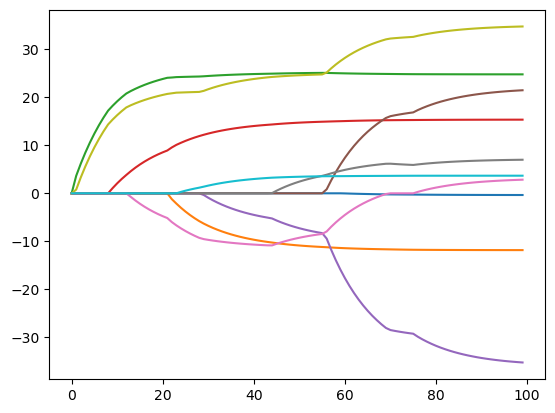

[ 0.    -0.    20.803  3.824  0.     0.    -0.     0.    17.905  0.   ]


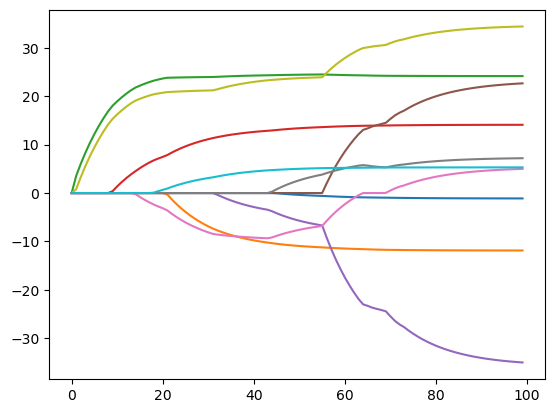

[ 0.    -0.    21.202  3.827  0.     0.    -0.     0.    18.516  0.   ]
############################ LASSO CONSTRAINED ##########################


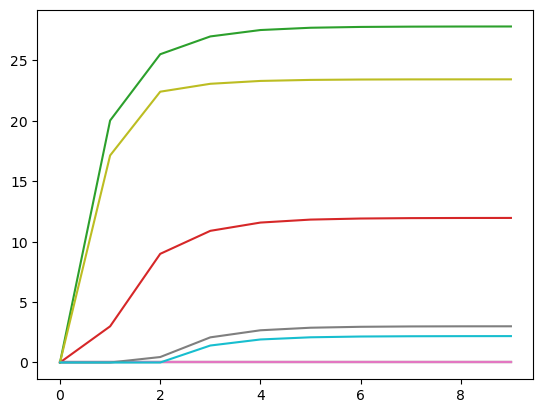

[ 0.     0.    20.032  2.993  0.     0.     0.     0.    17.139  0.   ]


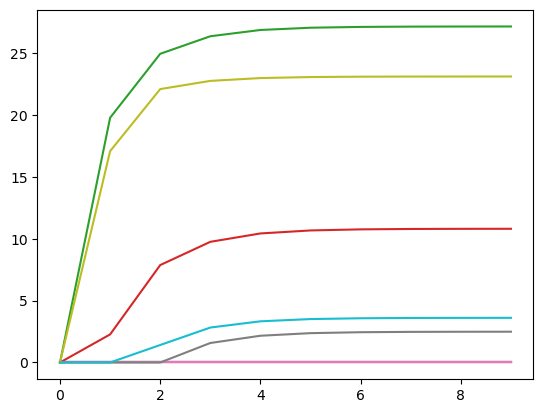

[ 0.    -0.    19.769  2.268  0.     0.    -0.     0.    17.072  0.   ]


In [ ]:
from ondil.estimators.online_linear_model import OnlineLinearModel
from ondil.methods import LassoPath, OrdinaryLeastSquares
import matplotlib.pyplot as plt

fit_intercept = False
scale_inputs = True

print("############################ OLS ##########################")
model = OnlineLinearModel(
    method="ols", fit_intercept=fit_intercept, scale_inputs=scale_inputs
)
model.fit(X[:-10, :], y[:-10])
print(model.beta)

model.update(X[-10:, :], y[-10:])
print(model.beta)


print("############################ LASSO ##########################")
model = OnlineLinearModel(
    method="lasso",  # default parameters
    fit_intercept=fit_intercept,
    scale_inputs=scale_inputs,
)
model.fit(X[:-10, :], y[:-10])
plt.plot(model.beta_path)
plt.show()
print(model.beta)


model.update(X[-10:, :], y[-10:])
plt.plot(model.beta_path)
plt.show()
print(model.beta)

print("############################ LASSO CONSTRAINED ##########################")

model = OnlineLinearModel(
    method=LassoPath(
        lambda_n=10,  # Only fit 10 lambdas
        beta_lower_bound=np.zeros(
            X.shape[1] + fit_intercept
        ),  # all positive parameters
    ),
    fit_intercept=fit_intercept,
    scale_inputs=scale_inputs,
)
model.fit(X[:-10, :], y[:-10])
plt.plot(model.beta_path)
plt.show()
print(model.beta)

model.update(X[-10:, :], y[-10:])
plt.plot(model.beta_path)
plt.show()
print(model.beta)